In [3]:
import os, re, glob, random, math, json, gc, pathlib, sys
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

print("TF:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TF: 2.18.0
GPU available: False


# Data Split

In [4]:
import os, re, shutil, random
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --------------------
# INPUTS (edit these)
# --------------------
DATA_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\DataSet_STO"      # folder with images
OUT_ROOT = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16"          # where to create Split/dev/{train,val} and Split/test
TEST_RATIO = 0.20                       #  0.20 → 80/20 dev/test
VAL_RATIO_WITHIN_DEV = 0.20             # 0.20 of dev → dev/val (so train is 0.80 of dev)
RECURSIVE = False                       # True if you want to collect from subfolders; False = top-level only
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# --------------------
# Label rules 
# --------------------
def infer_label_from_name(name: str):
    base = Path(name).stem
    if re.match(r"^Bulk", base, flags=re.IGNORECASE): return "Bulk"
    if re.match(r"^IExtra",        base, flags=re.IGNORECASE): return "Sub"
    if re.match(r"^Extra",         base, flags=re.IGNORECASE): return "Int"
    if re.match(r"^Mis",           base, flags=re.IGNORECASE): return "Vac"
    return None

# --------------------
# Collect TIFFs
# --------------------
p = Path(DATA_DIR)
exts = ("*.tif","*.tiff","*.TIF","*.TIFF")
hits = []
if RECURSIVE:
    for ext in exts:
        hits += list(p.rglob(ext))
else:
    for ext in exts:
        hits += list(p.glob(ext))

# Deduplicate by filename (case-insensitive)
hits = [q for q in hits if q.is_file()]
hits = sorted(hits, key=lambda q: q.name.lower())
seen = set(); files = []
for q in hits:
    key = q.name.lower()
    if key not in seen:
        seen.add(key)
        files.append(q)

print(f"Total unique TIFF files found: {len(files)}")

# Build dataframe with labels
df = pd.DataFrame({
    "path": [str(f) for f in files],
    "name": [f.name for f in files],
})
df["label"] = df["name"].apply(infer_label_from_name)

# Separate labeled vs unlabeled (None)
df_lab   = df[df["label"].notna()].copy()
df_unlab = df[df["label"].isna()].copy()
print("Labeled:", len(df_lab), "Unlabeled:", len(df_unlab))
print("Labeled class counts:\n", df_lab["label"].value_counts())

# --------------------
# 1) Split labeled data into DEV and TEST (stratified)
# --------------------
if len(df_lab) > 0:
    dev_lab, test_lab = train_test_split(
        df_lab, test_size=TEST_RATIO, random_state=SEED, stratify=df_lab["label"]
    )
else:
    dev_lab, test_lab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

# 2) Split unlabeled data into DEV and TEST (random with same ratio)
if len(df_unlab) > 0:
    test_unlab = df_unlab.sample(frac=TEST_RATIO, random_state=SEED)
    dev_unlab  = df_unlab.drop(test_unlab.index)
else:
    dev_unlab, test_unlab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

dev_df  = pd.concat([dev_lab, dev_unlab], ignore_index=True)
test_df = pd.concat([test_lab, test_unlab], ignore_index=True)

print(f"\nDEV total: {len(dev_df)}  (labeled={len(dev_lab)}, unlabeled={len(dev_unlab)})")
print(f"TEST total: {len(test_df)} (labeled={len(test_lab)}, unlabeled={len(test_unlab)})")
if len(dev_lab):
    print("DEV labeled class counts:\n", dev_lab["label"].value_counts())
if len(test_lab):
    print("TEST labeled class counts:\n", test_lab["label"].value_counts())

# --------------------
# 3) Inside DEV: split into TRAIN and VAL (stratified on labeled; random on unlabeled)
# --------------------
# Labeled portion
if len(dev_lab) > 0:
    train_lab, val_lab = train_test_split(
        dev_lab, test_size=VAL_RATIO_WITHIN_DEV, random_state=SEED, stratify=dev_lab["label"]
    )
else:
    train_lab, val_lab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

# Unlabeled portion
if len(dev_unlab) > 0:
    val_unlab = dev_unlab.sample(frac=VAL_RATIO_WITHIN_DEV, random_state=SEED)
    train_unlab = dev_unlab.drop(val_unlab.index)
else:
    train_unlab, val_unlab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

train_df = pd.concat([train_lab, train_unlab], ignore_index=True)
val_df   = pd.concat([val_lab,   val_unlab],   ignore_index=True)

print(f"\nTRAIN total: {len(train_df)}  (labeled={len(train_lab)}, unlabeled={len(train_unlab)})")
print(f"VAL   total: {len(val_df)}    (labeled={len(val_lab)},   unlabeled={len(val_unlab)})")
if len(train_lab):
    print("TRAIN labeled class counts:\n", train_lab["label"].value_counts())
if len(val_lab):
    print("VAL labeled class counts:\n", val_lab["label"].value_counts())

# --------------------
# 4) Create folders and COPY files
# --------------------
dev_train_dir = Path(OUT_ROOT) / "dev_STO" / "train"
dev_val_dir   = Path(OUT_ROOT) / "dev_STO" / "val"
test_dir      = Path(OUT_ROOT) / "test_STO"
for d in [dev_train_dir, dev_val_dir, test_dir]:
    d.mkdir(parents=True, exist_ok=True)

def _copy_rows(rows, dst_dir: Path):
    for src in rows["path"].tolist():
        dst = dst_dir / Path(src).name
        if not dst.exists():
            shutil.copy2(src, dst)

_copy_rows(train_df, dev_train_dir)
_copy_rows(val_df,   dev_val_dir)
_copy_rows(test_df,  test_dir)

print("\nDone.")
print(f"Copied → {dev_train_dir}  : {len(list(dev_train_dir.glob('*')))} files")
print(f"Copied → {dev_val_dir}    : {len(list(dev_val_dir.glob('*')))} files")
print(f"Copied → {test_dir}       : {len(list(test_dir.glob('*')))} files")


Total unique TIFF files found: 764
Labeled: 764 Unlabeled: 0
Labeled class counts:
 label
Bulk    225
Vac     201
Int     195
Sub     143
Name: count, dtype: int64

DEV total: 611  (labeled=611, unlabeled=0)
TEST total: 153 (labeled=153, unlabeled=0)
DEV labeled class counts:
 label
Bulk    180
Vac     161
Int     156
Sub     114
Name: count, dtype: int64
TEST labeled class counts:
 label
Bulk    45
Vac     40
Int     39
Sub     29
Name: count, dtype: int64

TRAIN total: 488  (labeled=488, unlabeled=0)
VAL   total: 123    (labeled=123,   unlabeled=0)
TRAIN labeled class counts:
 label
Bulk    144
Vac     128
Int     125
Sub      91
Name: count, dtype: int64
VAL labeled class counts:
 label
Bulk    36
Vac     33
Int     31
Sub     23
Name: count, dtype: int64

Done.
Copied → C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\dev_STO\train  : 488 files
Copied → C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\dev_STO\val    : 123 files
Copied → C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG

# Training

In [5]:
import os, re, numpy as np, tensorflow as tf
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TerminateOnNaN
from PIL import Image

# -------- PATHS from your split --------
ROOT          = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16"
DEV_TRAIN_DIR = rf"{ROOT}\dev_STO\train"
DEV_VAL_DIR   = rf"{ROOT}\dev_STO\val"
TEST_DIR      = rf"{ROOT}\test_STO"   

# -------- Global config --------
SEED = 42
IMG_H, IMG_W = 64, 64
RESIZE_H, RESIZE_W = 224, 224
BATCH_SIZE = 16
tf.random.set_seed(SEED); np.random.seed(SEED)

# -------- Helpers --------
def list_unique_top_level_tiffs(folder):
    p = Path(folder)
    hits = []
    for ext in ("*.tif","*.tiff","*.TIF","*.TIFF"):
        hits += list(p.glob(ext))
    hits = [q for q in hits if q.is_file()]
    hits = sorted(hits, key=lambda x: x.name.lower())
    seen=set(); out=[]
    for q in hits:
        k = q.name.lower()
        if k not in seen:
            seen.add(k); out.append(str(q))
    return out

def infer_label_from_name(name: str):
    base = Path(name).stem
    if re.match(r"^Bulk", base, flags=re.IGNORECASE): return "Bulk"
    if re.match(r"^IExtra",        base, flags=re.IGNORECASE): return "Sub"
    if re.match(r"^Extra",         base, flags=re.IGNORECASE): return "Int"
    if re.match(r"^Mis",           base, flags=re.IGNORECASE): return "Vac"
    return None

def load_grayscale_64(path):
    img = Image.open(path).convert("L").resize((IMG_W, IMG_H))
    arr = np.array(img, dtype=np.float32)
    if arr.max() > 1.0: arr = arr/255.0
    return arr

from tensorflow.keras.applications.vgg16 import preprocess_input
def preprocess_for_vgg(x):   
    x = tf.image.resize(x, (RESIZE_H, RESIZE_W))
    x = tf.image.grayscale_to_rgb(x)
    x = preprocess_input(x*255.0)
    return x

# -------- Load DEV train/val as arrays --------
train_files = list_unique_top_level_tiffs(DEV_TRAIN_DIR)
val_files   = list_unique_top_level_tiffs(DEV_VAL_DIR)

Xtr = np.expand_dims(np.stack([load_grayscale_64(f) for f in train_files], axis=0), axis=-1) 
Xva = np.expand_dims(np.stack([load_grayscale_64(f) for f in val_files],   axis=0), axis=-1)  

ytr_names = [infer_label_from_name(Path(f).name) for f in train_files]
yva_names = [infer_label_from_name(Path(f).name) for f in val_files]

# Encode labels (fit on DEV all classes)
le = LabelEncoder()
le.fit([n for n in (ytr_names+yva_names) if n is not None])

# filter out any None (unlabeled) to keep supervision clean
tr_keep = [i for i,y in enumerate(ytr_names) if y is not None]
va_keep = [i for i,y in enumerate(yva_names) if y is not None]

Xtr = Xtr[tr_keep]
Xva = Xva[va_keep]
ytr = le.transform([ytr_names[i] for i in tr_keep])
yva = le.transform([yva_names[i] for i in va_keep])

num_classes = len(le.classes_)
print("Classes:", list(le.classes_), "num_classes=", num_classes)
print("Train class counts:", Counter(ytr))
print("Val   class counts:", Counter(yva))

# Class weights (balanced)
cls_weights = compute_class_weight(class_weight="balanced", classes=np.unique(ytr), y=ytr)
class_weights = {int(c): float(w) for c,w in zip(np.unique(ytr), cls_weights)}
print("Class weights:", class_weights)

# ---------- tf.data pipelines ----------
AUTOTUNE = tf.data.AUTOTUNE
def ds_from_numpy(imgs, ys, shuffle=False, aug=False, batch=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((imgs, ys))
    def _map(x,y):
        x = preprocess_for_vgg(x)
        if aug:
            k = tf.random.uniform([], 0, 4, dtype=tf.int32)
            x = tf.image.rot90(x, k)
            x = tf.image.random_flip_left_right(x)
            x = tf.image.random_flip_up_down(x)
        return x,y
    if shuffle:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

dtr = ds_from_numpy(Xtr, ytr, shuffle=True,  aug=True)
dva = ds_from_numpy(Xva, yva, shuffle=False, aug=False)

# ---------- Manual label smoothing ----------
def sparse_ce_with_smoothing(num_classes, epsilon=0.05):
    cce = tf.keras.losses.CategoricalCrossentropy()
    @tf.function
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_one  = tf.one_hot(y_true, depth=num_classes)
        y_smooth = (1.0 - epsilon)*y_one + epsilon/float(num_classes)
        return cce(y_smooth, y_pred)
    return loss_fn

# ---------- Model: VGG16 + head ----------
inp  = layers.Input(shape=(RESIZE_H, RESIZE_W, 3))
base = VGG16(include_top=False, weights="imagenet", input_tensor=inp, pooling="avg")
base.trainable = False

x = layers.Dropout(0.4)(base.output)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(num_classes, activation="softmax")(x)
clf = models.Model(inp, out)

# ---------- Callbacks ----------
CKPT_DIR = os.path.join(ROOT, "_vgg16_ckpts"); os.makedirs(CKPT_DIR, exist_ok=True)

def cbs(stage_name, monitor="val_loss", mode="min", min_delta=5e-4, patience=7):
    return [
        EarlyStopping(
            monitor=monitor,
            mode=mode,
            patience=patience,
            min_delta=min_delta,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor=monitor,
            mode=mode,
            factor=0.5,
            patience=max(2, patience//2),
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join(CKPT_DIR, f"{stage_name}_best.keras"),
            monitor=monitor,
            mode=mode,
            save_best_only=True,
            verbose=1
        ),
        TerminateOnNaN()
    ]

hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

# ---------- Stage 1: Warmup ----------
clf.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=sparse_ce_with_smoothing(num_classes, epsilon=0.05),
            metrics=["accuracy"])
h1 = clf.fit(
    dtr, validation_data=dva, epochs=30,
    callbacks=cbs("warmup"),
    class_weight=class_weights, verbose=1
)
hist_acc     += h1.history.get("accuracy", [])
hist_val_acc += h1.history.get("val_accuracy", [])
hist_loss    += h1.history.get("loss", [])
hist_val_loss+= h1.history.get("val_loss", [])

# ---------- Stage 2: Unfreeze block5*  ----------
for layer in base.layers:
    if layer.name.startswith("block5"):
        layer.trainable = True
clf.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
            loss=sparse_ce_with_smoothing(num_classes, epsilon=0.05),
            metrics=["accuracy"])
h2 = clf.fit(
    dtr, validation_data=dva, epochs=30,
    callbacks=cbs("finetune_block5"),
    class_weight=class_weights, verbose=1
)
hist_acc     += h2.history.get("accuracy", [])
hist_val_acc += h2.history.get("val_accuracy", [])
hist_loss    += h2.history.get("loss", [])
hist_val_loss+= h2.history.get("val_loss", [])

# ---------- Stage 3: Unfreeze block4*+block5* ----------
for layer in base.layers:
    if layer.name.startswith(("block4","block5")):
        layer.trainable = True
clf.compile(optimizer=tf.keras.optimizers.Adam(1.5e-6),
            loss=sparse_ce_with_smoothing(num_classes, epsilon=0.03),
            metrics=["accuracy"])
h3 = clf.fit(
    dtr, validation_data=dva, epochs=40,
    callbacks=cbs("finetune_block45"),
    class_weight=class_weights, verbose=1
)
hist_acc     += h3.history.get("accuracy", [])
hist_val_acc += h3.history.get("val_accuracy", [])
hist_loss    += h3.history.get("loss", [])
hist_val_loss+= h3.history.get("val_loss", [])

# ---------- Validation evaluation ----------
va_loss, va_acc = clf.evaluate(dva, verbose=0)
print(f"\nValidation accuracy (best weights): {va_acc:.3f} | val_loss={va_loss:.4f}")

def ds_val_only(imgs, ys, batch=64):
    ds = tf.data.Dataset.from_tensor_slices((imgs, ys))
    ds = ds.map(lambda x,y: (preprocess_for_vgg(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

dva_plain = ds_val_only(Xva, yva)
val_probs = clf.predict(dva_plain, verbose=0)
pred = np.argmax(val_probs, axis=1)  
Yva  = yva                          

# ---------- baseline: frozen embedding + logistic regression ----------
print("\nRunning frozen-embedding logistic regression baseline...")
frozen = VGG16(include_top=False, weights="imagenet",
               input_shape=(RESIZE_H,RESIZE_W,3), pooling='avg')
frozen.trainable = False

def ds_plain(imgs, ys, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((imgs, ys))
    ds = ds.map(lambda x,y: (preprocess_for_vgg(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

def embed(ds):
    E, Y = [], []
    for xb, yb in ds:
        E.append(frozen.predict(xb, verbose=0))
        Y.append(yb.numpy())
    return np.vstack(E), np.concatenate(Y)

Etr, Ytr = embed(ds_plain(Xtr, ytr))
Eva, Yva_baseline = embed(ds_plain(Xva, yva))

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(Etr, Ytr)
val_pred = lr.predict(Eva)
print("Frozen-embedding logistic-reg VAL acc:", accuracy_score(Yva_baseline, val_pred))

# Keep histories for next cells
hist_acc, hist_val_acc, hist_loss, hist_val_loss = list(hist_acc), list(hist_val_acc), list(hist_loss), list(hist_val_loss)


Classes: ['Bulk', 'Int', 'Sub', 'Vac'] num_classes= 4
Train class counts: Counter({0: 144, 3: 128, 1: 125, 2: 91})
Val   class counts: Counter({0: 36, 3: 33, 1: 31, 2: 23})
Class weights: {0: 0.8472222222222222, 1: 0.976, 2: 1.3406593406593406, 3: 0.953125}
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.2553 - loss: 7.1686
Epoch 1: val_loss improved from inf to 2.36611, saving model to C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\_vgg16_ckpts\warmup_best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 996ms/step - accuracy: 0.2559 - loss: 7.1352 - val_accuracy: 0.2520 - val_loss: 2.3661 - learning_rate: 0.0010
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.2722 - loss: 4.4601
Epoch 2: val_loss improved from 2.36611 to 1.33385, saving model to C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\_vgg16_ckpts\warmup_best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 983ms/step - accuracy: 0.2724 - loss: 4.4511 - val_accuracy: 0.4553 - val_loss: 1.3339 - learning_rate: 0

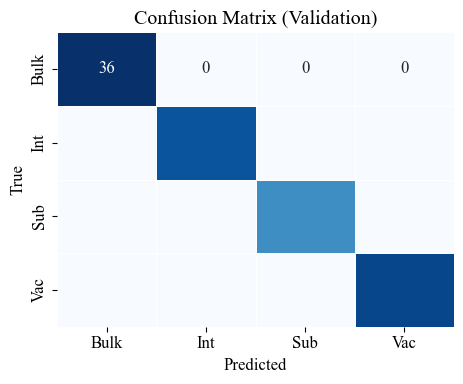

              precision    recall  f1-score   support

        Bulk       1.00      1.00      1.00        36
         Int       1.00      1.00      1.00        31
         Sub       1.00      1.00      1.00        23
         Vac       1.00      1.00      1.00        33

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123



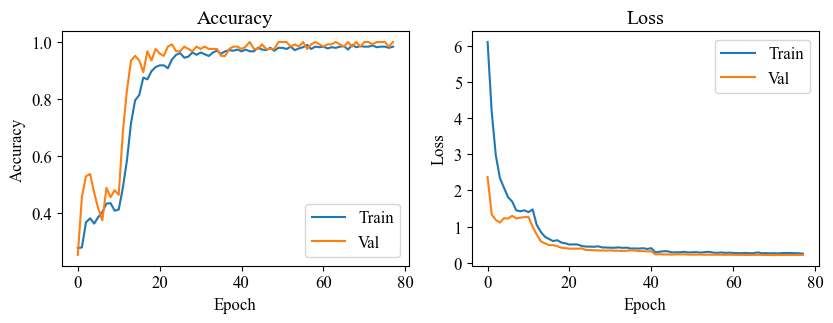

In [6]:
# === Plot Confusion Matrix + Training Curves
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

# ---- Global style ----
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

# =========================
# Config knobs
# =========================
FIGSIZE_CM   = (4.8, 4.0)   # Confusion Matrix
FIGSIZE_CURV = (8.5, 3.4)   # Training Curves

SAVE_CONFUSION_PATH = rf"{ROOT}\confusion_matrix.png"
SAVE_CURVES_PATH    = rf"{ROOT}\training_curves.png"

DPI_EXPORT   = 800
PAD_INCHES   = 0.03

def _save_current_figure(path, dpi=DPI_EXPORT, pad_inches=PAD_INCHES):
    if path is not None:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, dpi=dpi, bbox_inches='tight', pad_inches=pad_inches)

# ---- Confusion Matrix (on validation set) ----
try:
    _ = (Yva, pred, le)
    cm = confusion_matrix(Yva, pred, labels=np.arange(len(le.classes_)))
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(le.classes_), yticklabels=list(le.classes_),
                cbar=False, linewidths=0.5, linecolor='white')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Validation)")
    plt.tight_layout()
    _save_current_figure(SAVE_CONFUSION_PATH)
    plt.show()

    print(classification_report(Yva, pred, target_names=list(le.classes_)))
except NameError:
    print("Yva/pred/le missing → run the training cell first.")

# ---- Training Curves ----
try:
    _ = (hist_acc, hist_val_acc, hist_loss, hist_val_loss)
    plt.figure(figsize=FIGSIZE_CURV)

    plt.subplot(1, 2, 1)
    plt.plot(hist_acc, label="Train")
    plt.plot(hist_val_acc, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend(frameon=True)

    plt.subplot(1, 2, 2)
    plt.plot(hist_loss, label="Train")
    plt.plot(hist_val_loss, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(frameon=True)

    plt.tight_layout()
    _save_current_figure(SAVE_CURVES_PATH)
    plt.show()
except NameError:
    print("Training histories missing → run the training cell first.")


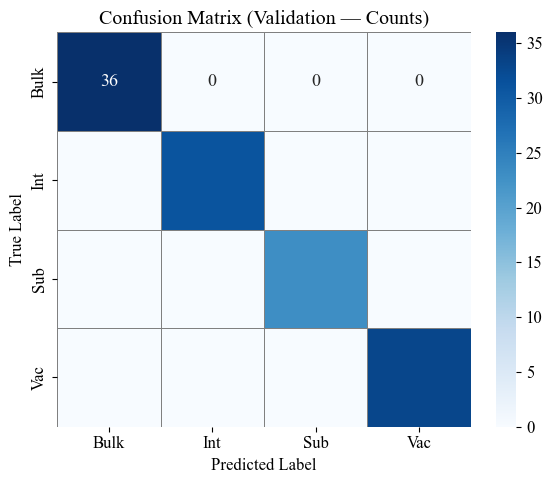

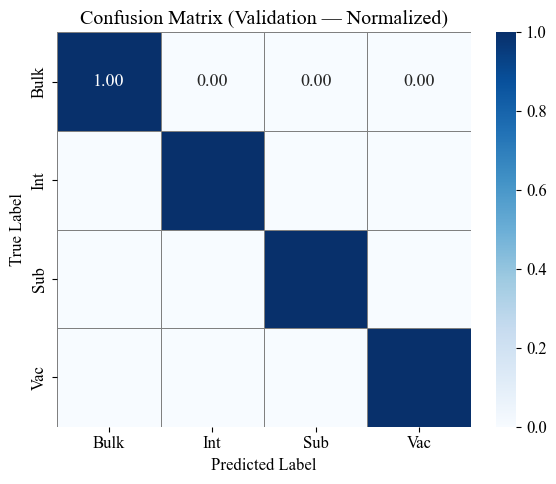


Classification Report (Validation):

              precision    recall  f1-score   support

        Bulk       1.00      1.00      1.00        36
         Int       1.00      1.00      1.00        31
         Sub       1.00      1.00      1.00        23
         Vac       1.00      1.00      1.00        33

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123



In [7]:
# ============================================================
# Confusion Matrix (Validation) 
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


assert "Yva" in globals(), "Yva not found — run training cell first"
assert "pred" in globals(), "pred not found — run prediction cell first"
assert "le"   in globals(), "LabelEncoder not found"

class_names = list(le.classes_)

# -----------------------
# Compute confusion matrices
# -----------------------
cm_counts = confusion_matrix(Yva, pred, labels=np.arange(len(class_names)))
cm_norm   = confusion_matrix(
    Yva, pred,
    labels=np.arange(len(class_names)),
    normalize="true"
)

# ============================================================
# Plot 1: RAW COUNTS
# ============================================================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_counts,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor="gray",
    cbar=True,
    annot_kws={"size": 13}
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation — Counts)")
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2: NORMALIZED (RECOMMENDED)
# ============================================================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor="gray",
    cbar=True,
    vmin=0.0,
    vmax=1.0,
    annot_kws={"size": 13}
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation — Normalized)")
plt.tight_layout()
plt.show()

print("\nClassification Report (Validation):\n")
print(classification_report(Yva, pred, target_names=class_names))


In [19]:
# === Extract embeddings from the trained classifier (penultimate GAP) ===
import numpy as np, tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

AUTOTUNE = tf.data.AUTOTUNE
BATCH = 64
RESIZE_H = RESIZE_W = 224

def make_infer_ds(images_64, batch=BATCH):
    ds = tf.data.Dataset.from_tensor_slices(images_64)
    ds = ds.map(lambda x: preprocess_for_vgg(x), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

# DEV embeddings = train+val
Xdev = np.concatenate([Xtr, Xva], axis=0)
dev_files = [*train_files, *val_files]

infer_ds_dev = make_infer_ds(Xdev)

# TEST set → load now as arrays
from PIL import Image
def load_grayscale_64(path):
    img = Image.open(path).convert("L").resize((64,64))
    arr = np.array(img, dtype=np.float32)
    if arr.max()>1.0: arr/=255.0
    return arr

test_files = [str(p) for p in Path(TEST_DIR).glob("*.tif")] \
           + [str(p) for p in Path(TEST_DIR).glob("*.tiff")] \
           + [str(p) for p in Path(TEST_DIR).glob("*.TIF")] \
           + [str(p) for p in Path(TEST_DIR).glob("*.TIFF")]
# dedup by name
test_files = sorted(list({Path(f).name.lower(): f for f in test_files}.values()))

Xtest = np.expand_dims(np.stack([load_grayscale_64(f) for f in test_files], axis=0), axis=-1)
infer_ds_test = make_infer_ds(Xtest)

# Build embedder from trained clf (GAP layer)
gap_layer = [L for L in clf.layers if isinstance(L, layers.GlobalAveragePooling2D)][-1]
embedder = tf.keras.Model(inputs=clf.input, outputs=gap_layer.output)  

# Compute embeddings
emb_dev  = np.vstack([embedder.predict(xb, verbose=0) for xb in infer_ds_dev]).astype(np.float32)
emb_test = np.vstack([embedder.predict(xb, verbose=0) for xb in infer_ds_test]).astype(np.float32)
print("Embeddings DEV :", emb_dev.shape)
print("Embeddings TEST:", emb_test.shape)

# Keep filenames for later
filenames_dev  = dev_files
filenames_test = test_files


Embeddings DEV : (611, 512)
Embeddings TEST: (153, 512)


C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:13

[DEV] Best silhouette = 0.6970 at PCA=2 , k=4
[TEST] Silhouette (DEV-trained PCA/KMeans) = 0.6841
Saved: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\_vgg16_features_trained\km_labels_TEST_p2_k4.csv


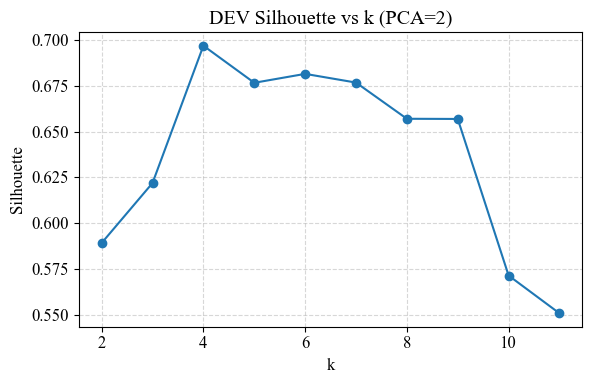

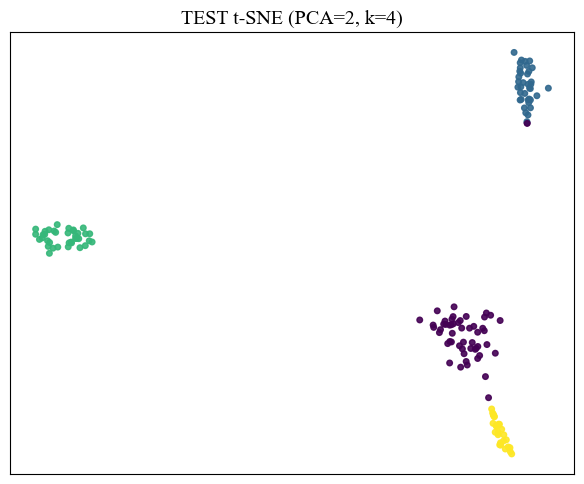

In [78]:
# === Grid on DEV; evaluate on TEST ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd, matplotlib.pyplot as plt

SEED = 42
pca_range = list(range(2, 20))
k_range   = list(range(2, 12))

scaler = StandardScaler()
Z_dev  = scaler.fit_transform(emb_dev)
Z_test = scaler.transform(emb_test)

best = {"score_dev": -1.0, "p": None, "k": None, "labels_dev": None, "pca_model": None, "km": None}
results = []
for p in pca_range:
    pca = PCA(n_components=p, random_state=SEED)
    Zp_dev = pca.fit_transform(Z_dev)
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
        lab = km.fit_predict(Zp_dev)
        s = silhouette_score(Zp_dev, lab)
        results.append((p,k,s))
        if s > best["score_dev"]:
            best = {"score_dev": float(s), "p": p, "k": k,
                    "labels_dev": lab.copy(), "pca_model": pca, "km": km}

print(f"[DEV] Best silhouette = {best['score_dev']:.4f} at PCA={best['p']} , k={best['k']}")

# TEST evaluation (transform + assign)
Zp_test = best["pca_model"].transform(Z_test)
labels_test_km = best["km"].predict(Zp_test)
sil_test = silhouette_score(Zp_test, labels_test_km)
print(f"[TEST] Silhouette (DEV-trained PCA/KMeans) = {sil_test:.4f}")

# Save labels for TEST
out_dir = os.path.join(ROOT, "_vgg16_features_trained")
os.makedirs(out_dir, exist_ok=True)
labels_csv = os.path.join(out_dir, f"km_labels_TEST_p{best['p']}_k{best['k']}.csv")
pd.DataFrame({"Filename": filenames_test, "Cluster": labels_test_km}).to_csv(labels_csv, index=False)
print("Saved:", labels_csv)

# Silhouette vs k at best PCA (DEV)
subset = sorted([(k,s) for (p,k,s) in results if p == best["p"]], key=lambda t: t[0])
ks, ss = zip(*subset)
plt.figure(figsize=(6,4))
plt.plot(ks, ss, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title(f"DEV Silhouette vs k (PCA={best['p']})")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout(); plt.show()

# t-SNE on best-PCA space (TEST)
from sklearn.manifold import TSNE
Z2 = TSNE(n_components=2, random_state=SEED, init="random", perplexity=min(30, len(Zp_test)-1), learning_rate="auto").fit_transform(Zp_test)
plt.figure(figsize=(6,5))
plt.scatter(Z2[:,0], Z2[:,1], c=labels_test_km, s=16, alpha=0.9)
plt.xticks([]); plt.yticks([]); plt.title(f"TEST t-SNE (PCA={best['p']}, k={best['k']})")
plt.tight_layout(); plt.show()

# Keep for downstream
best_p, best_k = best["p"], best["k"]


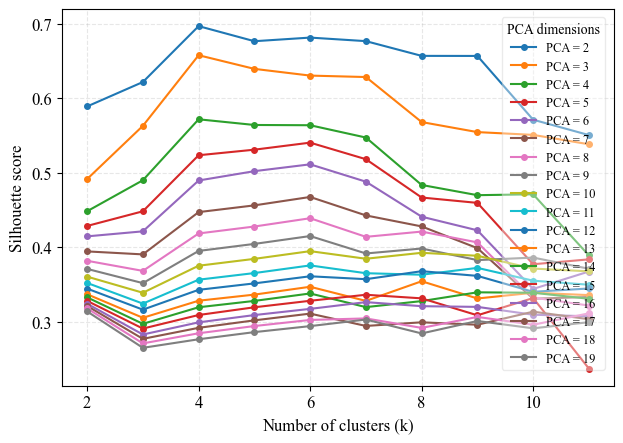

✔ Saved silhouette vs k plot for all PCA dimensions
📁 Location: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs


In [83]:
# =========================================================
# Silhouette vs k for ALL PCA dimensions 
# =========================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# -------------------------
# SAFETY CHECK
# -------------------------
assert "results" in globals(), "results not found — run grid search cell first"

# -------------------------
# OUTPUT DIRECTORY
# -------------------------
OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

DPI = 600
PAD = 0.03

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

LEGEND_LOC   = "upper right"     
LEGEND_BBOX  = (0.995, 0.995)     
LEGEND_ALPHA = 0.4             
LEGEND_NCOL  = 1               

silh_by_p = defaultdict(list)

for p, k, s in results:
    silh_by_p[p].append((k, s))

fig, ax = plt.subplots(figsize=(6.4, 4.6))

for p in sorted(silh_by_p.keys()):
    ks, ss = zip(*sorted(silh_by_p[p], key=lambda t: t[0]))
    ax.plot(
        ks,
        ss,
        marker="o",
        linewidth=1.5,
        markersize=4,
        label=f"PCA = {p}"
    )

ax.set_xlabel("Number of clusters (k)")
ax.set_ylabel("Silhouette score")

ax.grid(True, linestyle="--", alpha=0.3)

legend = ax.legend(
    title="PCA dimensions",
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=LEGEND_NCOL,
    fontsize=9,
    title_fontsize=10,
    frameon=True
)

legend.get_frame().set_alpha(LEGEND_ALPHA)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_DIR, "silhouette_vs_k_pca.png"),
    dpi=DPI,
    bbox_inches="tight",
    pad_inches=PAD
)

plt.show()
plt.close()


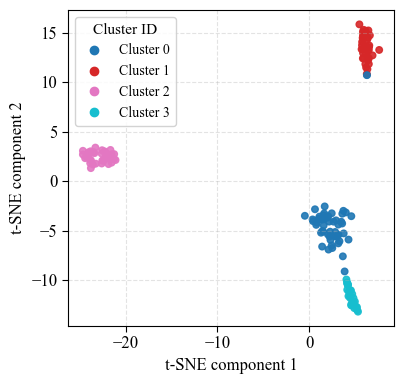

✔ Saved t-SNE clustering plot
📁 Location: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs


In [87]:
# =========================================================
# TEST CLUSTERING VISUALIZATION (t-SNE)
# =========================================================

import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

required = ["Zp_test", "labels_test_km", "best", "SEED"]
for r in required:
    assert r in globals(), f"{r} not found — run clustering cell first"

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

DPI = 600
PAD = 0.03

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

FIG_SIZE = (4.2, 4)
POINT_SIZE = 22
POINT_ALPHA = 0.9
COLORMAP = "tab10"

GRID_ALPHA = 0.35
GRID_STYLE = "--"

Z_tsne = TSNE(
    n_components=2,
    random_state=SEED,
    init="random",
    perplexity=min(30, len(Zp_test) - 1),
    learning_rate="auto"
).fit_transform(Zp_test)

fig, ax = plt.subplots(figsize=FIG_SIZE)

sc = ax.scatter(
    Z_tsne[:, 0],
    Z_tsne[:, 1],
    c=labels_test_km,
    s=POINT_SIZE,
    alpha=POINT_ALPHA,
    cmap=COLORMAP
)

ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")

ax.grid(True, linestyle=GRID_STYLE, alpha=GRID_ALPHA)

ax.tick_params(length=4)

handles, _ = sc.legend_elements(prop="colors", alpha=1.0)
legend = ax.legend(
    handles,
    [f"Cluster {i}" for i in range(best["k"])],
    title="Cluster ID",
    loc="best",
    fontsize=10,
    title_fontsize=11,
    frameon=True
)

legend.get_frame().set_alpha(0.85)

plt.tight_layout()
plt.savefig(
    os.path.join(
        OUT_DIR,
        f"test_tsne_clusters_pca{best['p']}_k{best['k']}.png"
    ),
    dpi=DPI,
    bbox_inches="tight",
    pad_inches=PAD
)

plt.show()
plt.close()

print("✔ Saved t-SNE clustering plot")
print(f"📁 Location: {OUT_DIR}")


## Clustering Accuracy

In [88]:
# Build df_features (TEST) & compute clustering purity ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]   = 12

def infer_label_from_name(name: str):
    base = Path(name).stem
    if re.match(r"^Bulk", base, flags=re.IGNORECASE): return "Bulk"
    if re.match(r"^IExtra",        base, flags=re.IGNORECASE): return "Sub"
    if re.match(r"^Extra",         base, flags=re.IGNORECASE): return "Int"
    if re.match(r"^Mis",           base, flags=re.IGNORECASE): return "Vac"
    return None

types_test = [infer_label_from_name(Path(f).name) for f in filenames_test]

pca_model = best["pca_model"]
Zp_test   = pca_model.transform(Z_test)  # from Cell 4
labels_best = labels_test_km

pca_cols = [f"PCA_{i+1}" for i in range(best_p)]
df_features = pd.DataFrame(Zp_test, columns=pca_cols)
df_features["Cluster"]  = labels_best
df_features["Filename"] = filenames_test
df_features["Type"]     = types_test

cluster_accuracies, cluster_sizes = [], []
print("\n[TEST] Cluster Accuracy Details (trained VGG16 embeddings):\n")
for c in range(best_k):
    cdf = df_features[df_features["Cluster"] == c]
    cluster_sizes.append(len(cdf))
    if cdf.empty:
        cluster_accuracies.append(0.0)
        print(f"Cluster {c}: EMPTY\n"); continue
    valid = cdf["Type"].dropna()
    if valid.empty:
        acc = 0.0; counts={}; major=None
    else:
        counts = valid.value_counts().to_dict()
        major  = valid.mode()[0]
        acc    = 100.0 * counts.get(major, 0)/len(cdf)
    cluster_accuracies.append(acc)
    print(f"Cluster {c}: n={len(cdf)}")
    print(f"  Type counts: {counts if len(valid)>0 else {}}")
    print(f"  Majority type: {major if len(valid)>0 else None}")
    print(f"  Purity accuracy: {acc:.2f}%\n")

overall_accuracy_mean     = float(np.mean(cluster_accuracies))
overall_accuracy_weighted = float(np.average(cluster_accuracies, weights=np.array(cluster_sizes)+1e-8))
print(f"[TEST] Overall Clustering Accuracy (mean of clusters): {overall_accuracy_mean:.2f}%")
print(f"[TEST] Overall Clustering Accuracy (sample-weighted):  {overall_accuracy_weighted:.2f}%")

best_num_clusters = best_k



[TEST] Cluster Accuracy Details (trained VGG16 embeddings):

Cluster 0: n=53
  Type counts: {'Bulk': 45, 'Sub': 3, 'Vac': 3, 'Int': 2}
  Majority type: Bulk
  Purity accuracy: 84.91%

Cluster 1: n=37
  Type counts: {'Vac': 37}
  Majority type: Vac
  Purity accuracy: 100.00%

Cluster 2: n=37
  Type counts: {'Int': 37}
  Majority type: Int
  Purity accuracy: 100.00%

Cluster 3: n=26
  Type counts: {'Sub': 26}
  Majority type: Sub
  Purity accuracy: 100.00%

[TEST] Overall Clustering Accuracy (mean of clusters): 96.23%
[TEST] Overall Clustering Accuracy (sample-weighted):  94.77%


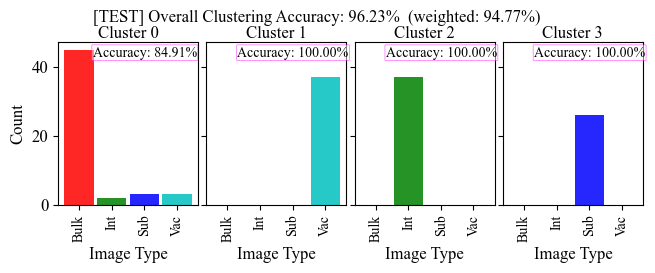

In [89]:
# Bar plot (TEST) ===
import matplotlib.pyplot as plt, os

figsize = (6.8, 2.5)
save_path = None  
dpi_export = 800; pad_inches = 0.03

markers = {'Bulk': 'o', 'Int': 'v', 'Sub': 'x', 'Vac': 's'}
colors  = {'Bulk': 'r', 'Int': 'g', 'Sub': 'b', 'Vac': 'c'}
hist_alpha = 0.85; wspace_value = 0.06
ylabel_fontsize = 12; xlabel_fontsize = 12; title_fontsize = 12; tick_fontsize = 10
accuracy_fontsize = 10; accuracy_x, accuracy_y = 0.62, 0.935

fig, axes = plt.subplots(1, best_num_clusters, figsize=figsize, sharey=True)
if best_num_clusters == 1: axes = [axes]

for c, ax in enumerate(axes):
    cdf = df_features[df_features["Cluster"] == c]
    if cdf.empty: ax.set_visible(False); continue
    type_counts = cdf["Type"].value_counts().reindex(colors.keys(), fill_value=0)
    ax.bar(type_counts.index, type_counts.values,
           color=[colors[t] for t in type_counts.index],
           alpha=hist_alpha, width=0.9)
    ax.set_title(f"Cluster {c}", fontsize=title_fontsize, pad=0.015)
    ax.set_xlabel("Image Type", fontsize=xlabel_fontsize)
    ax.tick_params(axis="x", rotation=90, labelsize=tick_fontsize)
    if c==0:
        ax.set_ylabel("Count", fontsize=ylabel_fontsize)
        ax.tick_params(axis="y", left=True, labelleft=True)
    else:
        ax.tick_params(axis="y", left=True, labelleft=False)
    acc = cluster_accuracies[c]
    ax.text(accuracy_x, accuracy_y, f"Accuracy: {acc:.2f}%",
            ha="center", va="center", transform=ax.transAxes, fontsize=accuracy_fontsize,
            bbox=dict(facecolor="white", edgecolor="magenta", boxstyle="round,pad=0.06", linewidth=0.6, alpha=0.5))

plt.subplots_adjust(left=0.12, right=0.98, bottom=0.2, top=0.85, wspace=wspace_value)
plt.suptitle(f"[TEST] Overall Clustering Accuracy: {overall_accuracy_mean:.2f}%  (weighted: {overall_accuracy_weighted:.2f}%)",
             fontsize=12, fontweight="normal")
if save_path:
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=dpi_export, bbox_inches='tight', pad_inches=pad_inches)
plt.show()


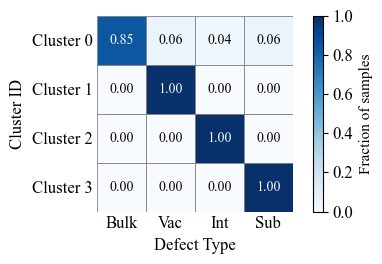

In [90]:
# =========================================================
# Cluster × Defect-Type COMPOSITION HEATMAP
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import os

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

dpi_export = 800
pad_inches = 0.03

defect_types = ["Bulk", "Vac", "Int", "Sub"]
K = best_num_clusters

comp = np.zeros((K, len(defect_types)))

for c in range(K):
    cdf = df_features[df_features["Cluster"] == c]
    if cdf.empty:
        continue
    total = len(cdf)
    for j, t in enumerate(defect_types):
        comp[c, j] = np.sum(cdf["Type"] == t) / total

fig, ax = plt.subplots(figsize=(5.8, 2.8))

norm = Normalize(vmin=0.0, vmax=1.0)
cmap = plt.cm.Blues

for i in range(K):
    for j in range(len(defect_types)):
        val = comp[i, j]
        ax.add_patch(
            plt.Rectangle(
                (j, K - 1 - i), 1, 1,
                facecolor=cmap(norm(val)),
                edgecolor="gray",
                linewidth=0.6
            )
        )
        ax.text(
            j + 0.5,
            K - 1 - i + 0.5,
            f"{val:.2f}",
            ha="center",
            va="center",
            fontsize=10,
            color="white" if val > 0.5 else "black"
        )

ax.set_xlim(0, len(defect_types))
ax.set_ylim(0, K)

ax.set_xticks(np.arange(len(defect_types)) + 0.5)
ax.set_xticklabels(defect_types)

ax.set_yticks(np.arange(K) + 0.5)
ax.set_yticklabels([f"Cluster {c}" for c in range(K)][::-1])

ax.set_xlabel("Defect Type")
ax.set_ylabel("Cluster ID")

ax.tick_params(length=0)
ax.set_aspect("equal")

for spine in ax.spines.values():
    spine.set_visible(False)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Fraction of samples", fontsize=11)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_DIR, "cluster_defect_composition_heatmap.png"),
    dpi=dpi_export,
    bbox_inches="tight",
    pad_inches=pad_inches
)

plt.show()   


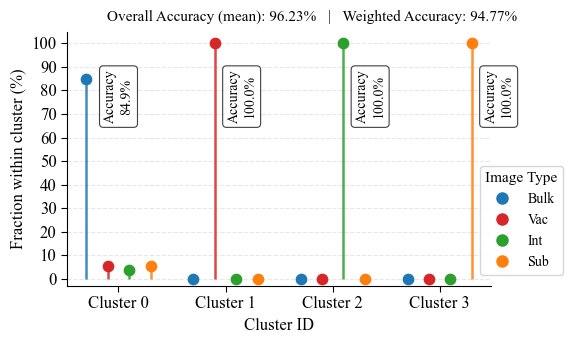

✔ Final grouped lollipop plot saved with full per-cluster control


In [92]:
# =========================================================
# GROUPED LOLLIPOP PLOT:
# Cluster × Image-Type Composition
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

assert "df_features" in globals(), "df_features not found"
assert "best_num_clusters" in globals(), "best_num_clusters not found"
assert "cluster_accuracies" in globals(), "cluster_accuracies not found"
assert "overall_accuracy_mean" in globals(), "overall_accuracy_mean not found"
assert "overall_accuracy_weighted" in globals(), "overall_accuracy_weighted not found"

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

dpi_export = 800
pad_inches = 0.03

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

image_types = ["Bulk", "Vac", "Int", "Sub"]
colors = {
    "Bulk": "tab:blue",
    "Vac":  "tab:red",
    "Int":  "tab:green",
    "Sub":  "tab:orange"
}

K = best_num_clusters
clusters = np.arange(K)

fractions = np.zeros((K, len(image_types)))

for c in range(K):
    cdf = df_features[df_features["Cluster"] == c]
    if cdf.empty:
        continue
    total = len(cdf)
    for j, t in enumerate(image_types):
        fractions[c, j] = np.sum(cdf["Type"] == t) / total

LINE_WIDTH   = 1.8
DOT_SIZE     = 55
GROUP_WIDTH  = 0.6

Y_MIN        = -3.0   
Y_MAX        = 105
Y_TICK_STEP  = 10

offsets = np.linspace(-GROUP_WIDTH/2, GROUP_WIDTH/2, len(image_types))


ANNOT_X_POS = [
    0.00,   # Cluster 0
    1.15,   # Cluster 1
    2.35,   # Cluster 2
    3.55    # Cluster 3
]

ANNOT_Y_POS = [
    66.0,   # Cluster 0
    66.0,   # Cluster 1
    66.0,   # Cluster 2
    66.0    # Cluster 3
]

ANNOT_ROTATION = 90
ANNOT_FONTSIZE = 10

BOX_PAD        = 0.28
BOX_EDGE_COLOR = "black"
BOX_FACE_COLOR = "white"
BOX_ALPHA      = 0.75
BOX_LINEWIDTH  = 0.8

assert len(ANNOT_X_POS) == K
assert len(ANNOT_Y_POS) == K

LEGEND_LOC   = "upper left"
LEGEND_BBOX  = (0.957, 0.5)
LEGEND_FRAME = True


fig, ax = plt.subplots(figsize=(6.8, 3.6))

# ---- Lollipops ----
for j, t in enumerate(image_types):
    x_pos = clusters + offsets[j]
    y_val = fractions[:, j] * 100.0

    for x, y in zip(x_pos, y_val):
        ax.vlines(
            x,
            ymin=0,
            ymax=y,
            color=colors[t],
            linewidth=LINE_WIDTH,
            alpha=0.85
        )
        ax.scatter(
            x,
            y,
            s=DOT_SIZE,
            color=colors[t],
            zorder=3
        )

ax.set_xticks(clusters)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Fraction within cluster (%)")

ax.set_ylim(Y_MIN, Y_MAX)
ax.set_yticks(np.arange(0, 101, Y_TICK_STEP))

ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.tick_params(length=4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for c in range(K):
    acc = cluster_accuracies[c]

    ax.text(
        ANNOT_X_POS[c],
        ANNOT_Y_POS[c],
        f"Accuracy\n{acc:.1f}%",
        rotation=ANNOT_ROTATION,
        ha="center",
        va="bottom",
        fontsize=ANNOT_FONTSIZE,
        bbox=dict(
            boxstyle=f"round,pad={BOX_PAD}",
            edgecolor=BOX_EDGE_COLOR,
            facecolor=BOX_FACE_COLOR,
            linewidth=BOX_LINEWIDTH,
            alpha=BOX_ALPHA
        ),
        zorder=5
    )

legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        markerfacecolor=colors[t],
        markeredgecolor=colors[t],
        markersize=8,
        label=t
    )
    for t in image_types
]

ax.legend(
    handles=legend_handles,
    title="Image Type",
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    frameon=LEGEND_FRAME,
    fontsize=10,
    title_fontsize=11
)

fig.text(
    0.47, 0.95,
    f"Overall Accuracy (mean): {overall_accuracy_mean:.2f}%   |   "
    f"Weighted Accuracy: {overall_accuracy_weighted:.2f}%",
    ha="center",
    va="top",
    fontsize=11
)

plt.tight_layout(rect=[0, 0, 0.86, 0.94])
plt.savefig(
    os.path.join(OUT_DIR, "cluster_image_type_lollipop_with_accuracy.png"),
    dpi=dpi_export,
    bbox_inches="tight",
    pad_inches=pad_inches
)

plt.show()
plt.close()


# Defect Localization

In [142]:
BIG_IMAGE_PATH = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\20111206_Test.tif"

img_big = Image.open(BIG_IMAGE_PATH).convert("L")
#img_big = img_big.resize((512, 512)) 
big_img = np.array(img_big, dtype=np.float32)

if big_img.max() > 1.0:
    big_img /= 255.0

H, W = big_img.shape
print("Big image shape:", big_img.shape)


Big image shape: (512, 512)


In [143]:
PATCH = 64

def extract_patches(img, patch=64):
    patches = []
    coords = []
    for i in range(0, img.shape[0], patch):
        for j in range(0, img.shape[1], patch):
            p = img[i:i+patch, j:j+patch]
            if p.shape == (patch, patch):
                patches.append(p)
                coords.append((i, j))
    return np.array(patches), coords

patches, coords = extract_patches(big_img, PATCH)
print("Number of patches:", len(patches))


Number of patches: 64


In [144]:
patches = np.expand_dims(patches, axis=-1)  

def make_infer_ds(images_64, batch=32):
    ds = tf.data.Dataset.from_tensor_slices(images_64)
    ds = ds.map(lambda x: preprocess_for_vgg(x),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

infer_ds = make_infer_ds(patches)

In [145]:
embeddings = np.vstack([
    embedder.predict(xb, verbose=0) for xb in infer_ds
]).astype(np.float32)

print("Embedding shape:", embeddings.shape)


Embedding shape: (64, 512)


In [146]:
# =========================================================
# Assign clusters to image patches 
# =========================================================
# Transform embeddings using DEV-trained PCA + KMeans
Z  = scaler.transform(embeddings)
Zp = best["pca_model"].transform(Z)

cluster_ids = best["km"].predict(Zp)

print("Assigned cluster IDs:", cluster_ids)
print("Number of patches:", len(cluster_ids))


Assigned cluster IDs: [0 0 0 0 0 0 0 0 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0]
Number of patches: 64


In [147]:
PATCH = 64
GRID  = 512 // PATCH

cluster_map = np.zeros((GRID, GRID), dtype=int)

for idx, (i, j) in enumerate(coords):
    r = i // PATCH
    c = j // PATCH
    cluster_map[r, c] = cluster_ids[idx]

print("Cluster map shape:", cluster_map.shape)

Cluster map shape: (8, 8)


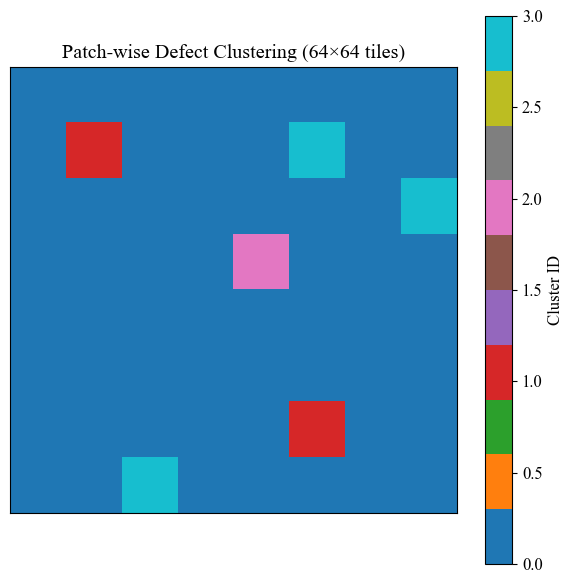

In [148]:
# =========================================================
# Visualize patch-wise clustering
# =========================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.figure(figsize=(6, 6))
im = plt.imshow(cluster_map, cmap="tab10", interpolation="nearest")
plt.xticks([])
plt.yticks([])
plt.title("Patch-wise Defect Clustering (64×64 tiles)")
plt.colorbar(im, label="Cluster ID")

plt.tight_layout()
plt.show()


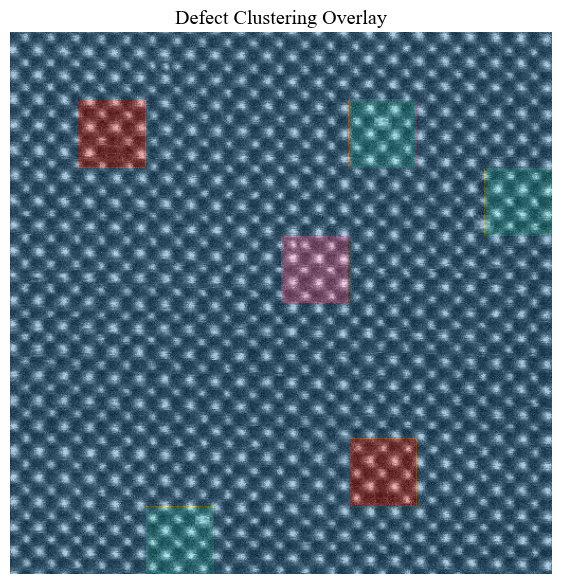

In [149]:
# =========================================================
# Overlay cluster map on original image
# =========================================================
plt.figure(figsize=(6, 6))
plt.imshow(big_img, cmap="gray")

overlay = cluster_map.repeat(PATCH, axis=0).repeat(PATCH, axis=1)
plt.imshow(overlay, cmap="tab10", alpha=0.35)

plt.axis("off")
plt.title("Defect Clustering Overlay")
plt.tight_layout()
plt.show()

# Supervised prediction on tiles (4-class labeling)

In [150]:
# =========================================================
# Supervised tile-level prediction (4 defect types)
# =========================================================
import numpy as np
import tensorflow as tf

infer_ds_tiles = make_infer_ds(patches, batch=32)

probs = np.vstack([
    clf.predict(xb, verbose=0) for xb in infer_ds_tiles
])

# Get predicted class + confidence
pred_class_ids = np.argmax(probs, axis=1)
pred_conf      = np.max(probs, axis=1)

# Decode class names
pred_labels = le.inverse_transform(pred_class_ids)

print("Supervised labels (first 10):")
for i in range(10):
    print(pred_labels[i], f"(conf={pred_conf[i]:.2f})")


Supervised labels (first 10):
Bulk (conf=0.92)
Bulk (conf=0.92)
Bulk (conf=0.73)
Bulk (conf=0.86)
Bulk (conf=0.71)
Bulk (conf=0.93)
Bulk (conf=0.88)
Bulk (conf=0.91)
Bulk (conf=0.89)
Vac (conf=1.00)


In [151]:
# =========================================================
# Unsupervised cluster assignment (k clusters)
# =========================================================

Z  = scaler.transform(embeddings)
Zp = best["pca_model"].transform(Z)

cluster_ids = best["km"].predict(Zp)

print("Cluster IDs (first 10):", cluster_ids[:10])


Cluster IDs (first 10): [0 0 0 0 0 0 0 0 0 1]


In [152]:
# =========================================================
# Build tile-level metadata table
# =========================================================
import pandas as pd

tile_rows = []
for idx, (i, j) in enumerate(coords):
    tile_rows.append({
        "tile_row": i // PATCH,
        "tile_col": j // PATCH,
        "x_px": j,
        "y_px": i,
        "Supervised_Label": pred_labels[idx],
        "Supervised_Confidence": pred_conf[idx],
        "Cluster_ID": cluster_ids[idx]
    })

df_tiles = pd.DataFrame(tile_rows)

print(df_tiles.head())


   tile_row  tile_col  x_px  y_px Supervised_Label  Supervised_Confidence  \
0         0         0     0     0             Bulk               0.920312   
1         0         1    64     0             Bulk               0.919351   
2         0         2   128     0             Bulk               0.734569   
3         0         3   192     0             Bulk               0.864474   
4         0         4   256     0             Bulk               0.707230   

   Cluster_ID  
0           0  
1           0  
2           0  
3           0  
4           0  


## Visualization: Supervised defect-type map

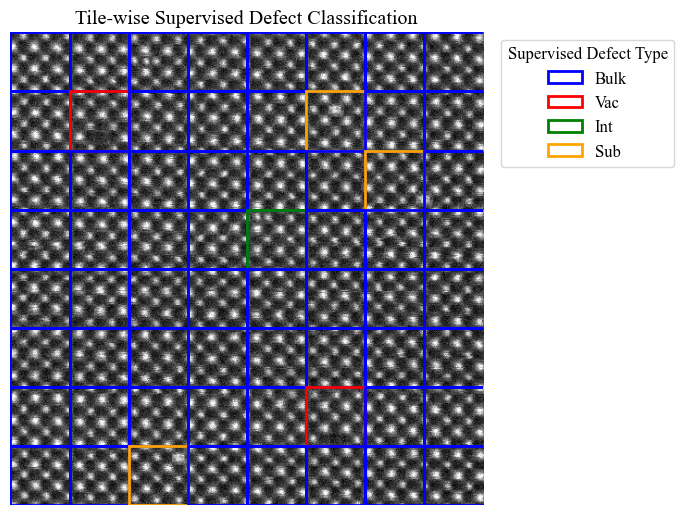

In [153]:
# =========================================================
# Visualization: Supervised defect-type map
# =========================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import matplotlib.cm as cm

label_color_map = {
    "Bulk": "blue",
    "Vac": "red",
    "Int": "green",
    "Sub": "orange"
}

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    color = label_color_map[label]

    rect = Rectangle(
        (j, i),
        PATCH, PATCH,
        linewidth=2.0,
        edgecolor=color,
        facecolor="none"
    )
    ax.add_patch(rect)

legend_handles = [
    Patch(facecolor="none", edgecolor=c, linewidth=2, label=l)
    for l, c in label_color_map.items()
]

ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Supervised Defect Type"
)

ax.set_title("Tile-wise Supervised Defect Classification")
plt.tight_layout()
plt.show()


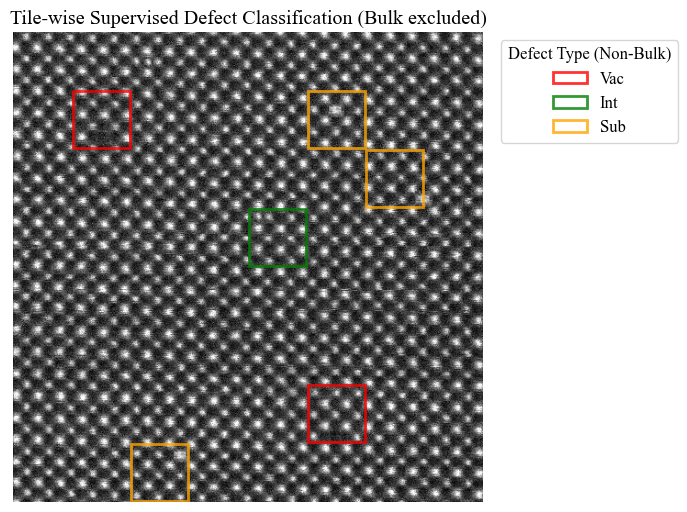

In [155]:
# =========================================================
# Visualization: Supervised defect-type map 
# EXCLUDING Bulk tiles
# =========================================================
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

TILE_SIZE      = 62     
BOUNDARY_ALPHA = 0.8
BOUNDARY_WIDTH = 2

label_color_map = {
    "Bulk": "blue",   
    "Vac":  "red",
    "Int":  "green",
    "Sub":  "orange"
}

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]

    # >>> SKIP BULK TILES <<<
    if label == "Bulk":
        continue

    color = label_color_map[label]

    rect = Rectangle(
        (j, i),                 
        TILE_SIZE, TILE_SIZE,
        linewidth=BOUNDARY_WIDTH,
        edgecolor=color,
        facecolor="none",
        alpha=BOUNDARY_ALPHA
    )
    ax.add_patch(rect)

legend_handles = [
    Patch(
        facecolor="none",
        edgecolor=color,
        linewidth=BOUNDARY_WIDTH,
        alpha=BOUNDARY_ALPHA,
        label=label
    )
    for label, color in label_color_map.items()
    if label != "Bulk"
]

ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Defect Type (Non-Bulk)",
    frameon=True
)

ax.set_title("Tile-wise Supervised Defect Classification (Bulk excluded)")
plt.tight_layout()
plt.show()


In [156]:
# =========================================================
# Compute tile-center (x, y) coordinates for defect tiles
# =========================================================

TILE_SIZE = 64

tile_centers = []

print("\nDefect tile center coordinates (in pixels):\n")

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]

    # Skip Bulk tiles
    if label == "Bulk":
        continue

    x_center = j + TILE_SIZE // 2
    y_center = i + TILE_SIZE // 2

    tile_centers.append({
        "Tile_Row": i // TILE_SIZE,
        "Tile_Col": j // TILE_SIZE,
        "x_px": x_center,
        "y_px": y_center,
        "Defect_Type": label,
        "Confidence": pred_conf[idx],
        "Cluster_ID": cluster_ids[idx]
    })

    print(
        f"Tile ({i//TILE_SIZE:2d}, {j//TILE_SIZE:2d})  →  "
        f"x = {x_center:4d}, y = {y_center:4d}  |  "
        f"{label:>4s}  (conf={pred_conf[idx]:.2f}), "
        f"Cluster {cluster_ids[idx]}"
    )

df_tile_centers = pd.DataFrame(tile_centers)



Defect tile center coordinates (in pixels):

Tile ( 1,  1)  →  x =   96, y =   96  |   Vac  (conf=1.00), Cluster 1
Tile ( 1,  5)  →  x =  352, y =   96  |   Sub  (conf=1.00), Cluster 3
Tile ( 2,  6)  →  x =  416, y =  160  |   Sub  (conf=0.83), Cluster 0
Tile ( 3,  4)  →  x =  288, y =  224  |   Int  (conf=0.86), Cluster 2
Tile ( 6,  5)  →  x =  352, y =  416  |   Vac  (conf=0.93), Cluster 1
Tile ( 7,  2)  →  x =  160, y =  480  |   Sub  (conf=1.00), Cluster 3


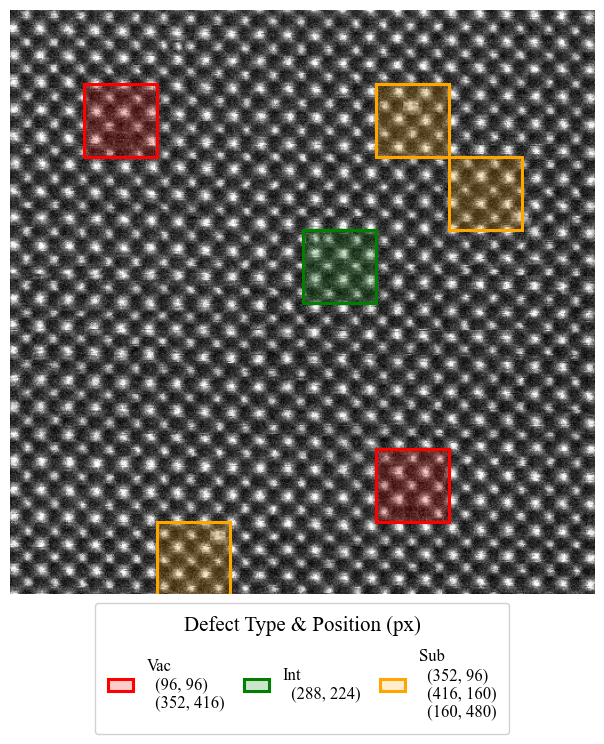

✔ Defect map saved (positions embedded inside legend box)
📁 Location: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs


In [172]:

import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import to_rgba

required = ["big_img", "coords", "pred_labels", "pred_conf", "cluster_ids"]
for r in required:
    assert r in globals(), f"{r} not found"

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\STO_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

DPI = 600
PAD = 0.03

plt.rcParams["font.family"] = "Times New Roman"

TILE_SIZE        = 64
BOUNDARY_WIDTH = 2.2
EDGE_ALPHA     = 1.0     
FILL_ALPHA     = 0.2     
FILL_TILES       = True
FILL_ALPHA       = 0.2

TITLE_FONTSIZE   = 12
LEGEND_FONTSIZE  = 12
LEGEND_TITLE_FS  = 15

label_color_map = {
    "Vac": "red",
    "Int": "green",
    "Sub": "orange"
}

positions_by_type = {k: [] for k in label_color_map.keys()}

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    if label == "Bulk":
        continue

    x_center = j + TILE_SIZE // 2
    y_center = i + TILE_SIZE // 2

    positions_by_type[label].append((x_center, y_center))

from matplotlib.colors import to_rgba

legend_handles = []

for label, color in label_color_map.items():
    pos_list = positions_by_type[label]

    if len(pos_list) == 0:
        pos_text = "  None"
    else:
        pos_text = "\n".join([f"  ({x}, {y})" for x, y in pos_list])

    legend_label = f"{label}\n{pos_text}"

    # --- SOLID EDGE + TRANSPARENT FILL ---
    edge_rgba = to_rgba(color, 1.0)                
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    legend_handles.append(
        Patch(
            edgecolor=edge_rgba,
            facecolor=face_rgba,
            linewidth=BOUNDARY_WIDTH,
            label=legend_label
        )
    )

fig, ax = plt.subplots(figsize=(7.6, 7.6))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    if label == "Bulk":
        continue

    color = label_color_map[label]

    edge_rgba = to_rgba(color, EDGE_ALPHA)
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    rect = Rectangle(
        (j, i),
        TILE_SIZE,
        TILE_SIZE,
        linewidth=BOUNDARY_WIDTH,
        edgecolor=edge_rgba,   # <<< SOLID, SHARP EDGE
        facecolor=face_rgba   # <<< TRANSPARENT FILL
    )

    ax.add_patch(rect)

legend = ax.legend(
    handles=legend_handles,
    ncol=3,                              # <<< 3 columns
    loc="upper center",
    bbox_to_anchor=(0.5, 0),         # <<< below the axes
    fontsize=LEGEND_FONTSIZE,
    title="Defect Type & Position (px)",
    title_fontsize=LEGEND_TITLE_FS,
    frameon=True,
    handlelength=1.5,
    handletextpad=0.8,
    borderpad=0.8,
    labelspacing=0.8,
    columnspacing=1.2                  
)

legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_DIR, "defect_map_with_positions_in_legend.png"),
    dpi=DPI,
    bbox_inches="tight",
    pad_inches=PAD
)

plt.show()
plt.close()

print("✔ Defect map saved (positions embedded inside legend box)")
print(f"📁 Location: {OUT_DIR}")
